In [ ]:
import pandas as pds
import numpy as np
import os

In [ ]:
# metadata zip
!wget https://dataverse.harvard.edu/api/access/datafile/4338392
os.rename('4338392', 'HAM10000_metadata')

--2023-09-18 12:41:04--  https://dataverse.harvard.edu/api/access/datafile/4338392
Resolving dataverse.harvard.edu (dataverse.harvard.edu)... 54.210.73.15, 107.23.117.208, 34.227.244.46
Connecting to dataverse.harvard.edu (dataverse.harvard.edu)|54.210.73.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 830428 (811K) [text/tab-separated-values]
Saving to: ‘4338392’

4338392             100%[===================>] 810.96K  --.-KB/s    in 0.1s    

2023-09-18 12:41:04 (8.18 MB/s) - ‘4338392’ saved [830428/830428]



In [ ]:
!mkdir metadatas
!mv HAM10000_metadata /content/metadatas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [ ]:
skin_df = pd.read_csv('/content/metadatas/HAM10000_metadata', sep='\t', header=None)
skin_df.to_csv('HAM10000_metadata.csv', header=None)

!mv 'HAM10000_metadata.csv' /content/metadatas

skin_df = pd.read_csv('/content/metadatas/HAM10000_metadata.csv')

print(skin_df)
print("Number of lines present:-", len(skin_df))

           0    lesion_id      image_id     dx dx_type   age     sex  \
0          1  HAM_0000118  ISIC_0027419    bkl   histo  80.0    male   
1          2  HAM_0000118  ISIC_0025030    bkl   histo  80.0    male   
2          3  HAM_0002730  ISIC_0026769    bkl   histo  80.0    male   
3          4  HAM_0002730  ISIC_0025661    bkl   histo  80.0    male   
4          5  HAM_0001466  ISIC_0031633    bkl   histo  75.0    male   
...      ...          ...           ...    ...     ...   ...     ...   
10010  10011  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male   
10011  10012  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male   
10012  10013  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male   
10013  10014  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male   
10014  10015  HAM_0003521  ISIC_0032258    mel   histo  70.0  female   

      localization       dataset  
0            scalp  vidir_modern  
1            scalp  vidir_modern  
2            scalp  vidir_mode

In [ ]:
# image masks zip
!wget https://dataverse.harvard.edu/api/access/datafile/3838943
os.rename('3838943', 'maks_imgs')

!mkdir masks
!unzip maks_imgs -d /content/masks
# images zip 1
!wget https://dataverse.harvard.edu/api/access/datafile/3172585
os.rename('3172585', 'imgs_1')

!mkdir imgs
!unzip imgs_1 -d /content/imgs

# images zip 2
!wget https://dataverse.harvard.edu/api/access/datafile/3172584
os.rename('3172584', 'imgs_2')

!unzip imgs_2 -d /content/imgs

Streaming output truncated to the last 5000 lines.
  inflating: /content/imgs/ISIC_0029321.jpg  
  inflating: /content/imgs/ISIC_0029322.jpg  
  inflating: /content/imgs/ISIC_0029323.jpg  
  inflating: /content/imgs/ISIC_0029324.jpg  
  inflating: /content/imgs/ISIC_0029325.jpg  
  inflating: /content/imgs/ISIC_0029326.jpg  
  inflating: /content/imgs/ISIC_0029327.jpg  
  inflating: /content/imgs/ISIC_0029328.jpg  
  inflating: /content/imgs/ISIC_0029329.jpg  
  inflating: /content/imgs/ISIC_0029330.jpg  
  inflating: /content/imgs/ISIC_0029331.jpg  
  inflating: /content/imgs/ISIC_0029332.jpg  
  inflating: /content/imgs/ISIC_0029333.jpg  
  inflating: /content/imgs/ISIC_0029334.jpg  
  inflating: /content/imgs/ISIC_0029335.jpg  
  inflating: /content/imgs/ISIC_0029336.jpg  
  inflating: /content/imgs/ISIC_0029337.jpg  
  inflating: /content/imgs/ISIC_0029338.jpg  
  inflating: /content/imgs/ISIC_0029339.jpg  
  inflating: /content/imgs/ISIC_0029340.jpg  
  inflating: /content/imgs/IS

In [ ]:
mask_img_list = os.listdir('/content/masks/HAM10000_segmentations_lesion_tschandl')
df_mask_images = pds.DataFrame(mask_img_list, columns=['image_id'])

print('size: ', df_mask_images.size)
df_mask_images.head(10)

size:  10015


,image_id
0,ISIC_0025607_segmentation.png
1,ISIC_0025136_segmentation.png
2,ISIC_0027553_segmentation.png
3,ISIC_0026531_segmentation.png
4,ISIC_0024800_segmentation.png
5,ISIC_0031472_segmentation.png
6,ISIC_0026872_segmentation.png
7,ISIC_0028905_segmentation.png
8,ISIC_0024453_segmentation.png
9,ISIC_0029322_segmentation.png


In [ ]:
img_list = os.listdir('/content/imgs/')
df_images = pds.DataFrame(img_list, columns=['image_id'])

print('size: ', df_images.size)
df_images.head(10)

size:  10015


,image_id
0,ISIC_0026043.jpg
1,ISIC_0026631.jpg
2,ISIC_0029605.jpg
3,ISIC_0028834.jpg
4,ISIC_0024546.jpg
5,ISIC_0026203.jpg
6,ISIC_0033311.jpg
7,ISIC_0032222.jpg
8,ISIC_0025412.jpg
9,ISIC_0027678.jpg


In [ ]:
SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df["dx"])
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
         0    lesion_id      image_id   dx    dx_type   age     sex  \
1617  1618  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  8129  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  2169  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  1091  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  7755  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  8072  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  7424  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  8985  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  2311  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  7257  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization        dataset  label  
1617             face   vidir_modern      4  
8128  lower extremity    vienna_dias      5  
2168             back      ro

<ipython-input-10-9c594ee24d5f>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


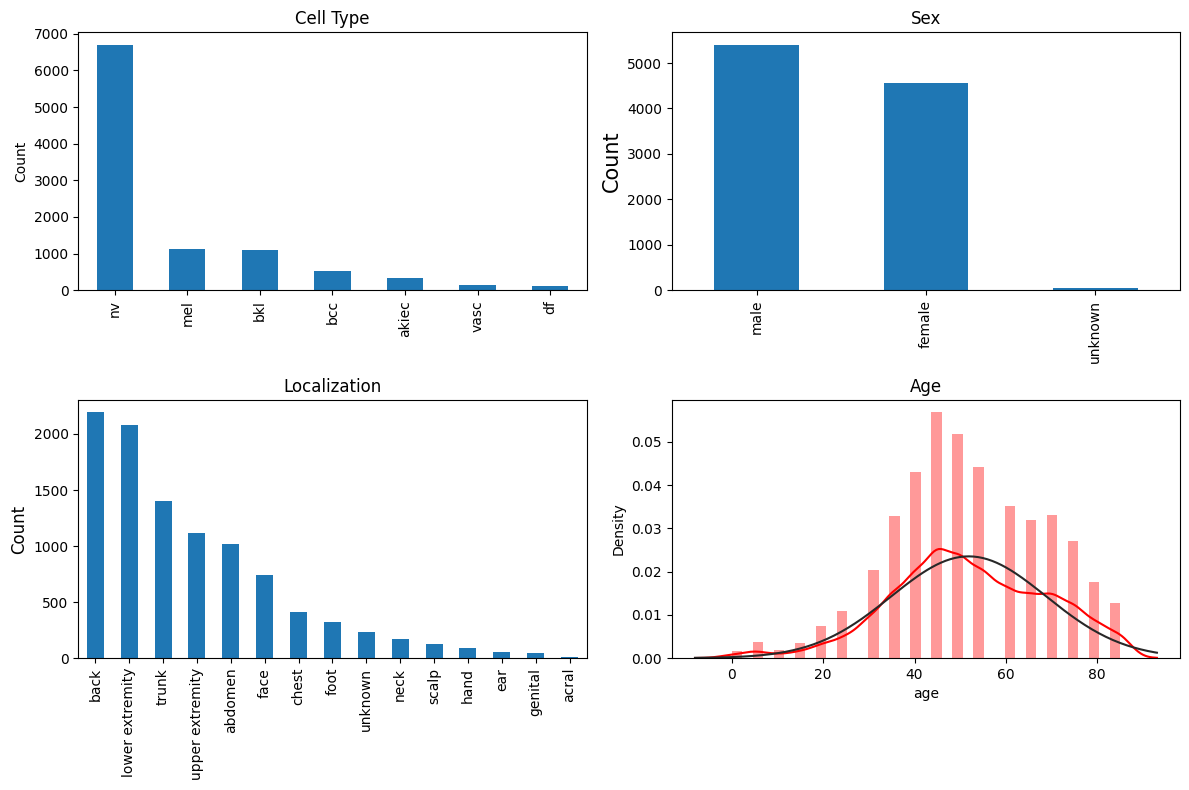

In [ ]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [ ]:
# Distribution of data into various classes
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [ ]:
# Balance data.
# Many ways to balance data...
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

# Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced,
                              df_2_balanced, df_3_balanced,
                              df_4_balanced, df_5_balanced, df_6_balanced])

# Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [ ]:
# Now time to read images based on image ID from the CSV file
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/imgs/', '*.jpg'))}

# Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
# Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

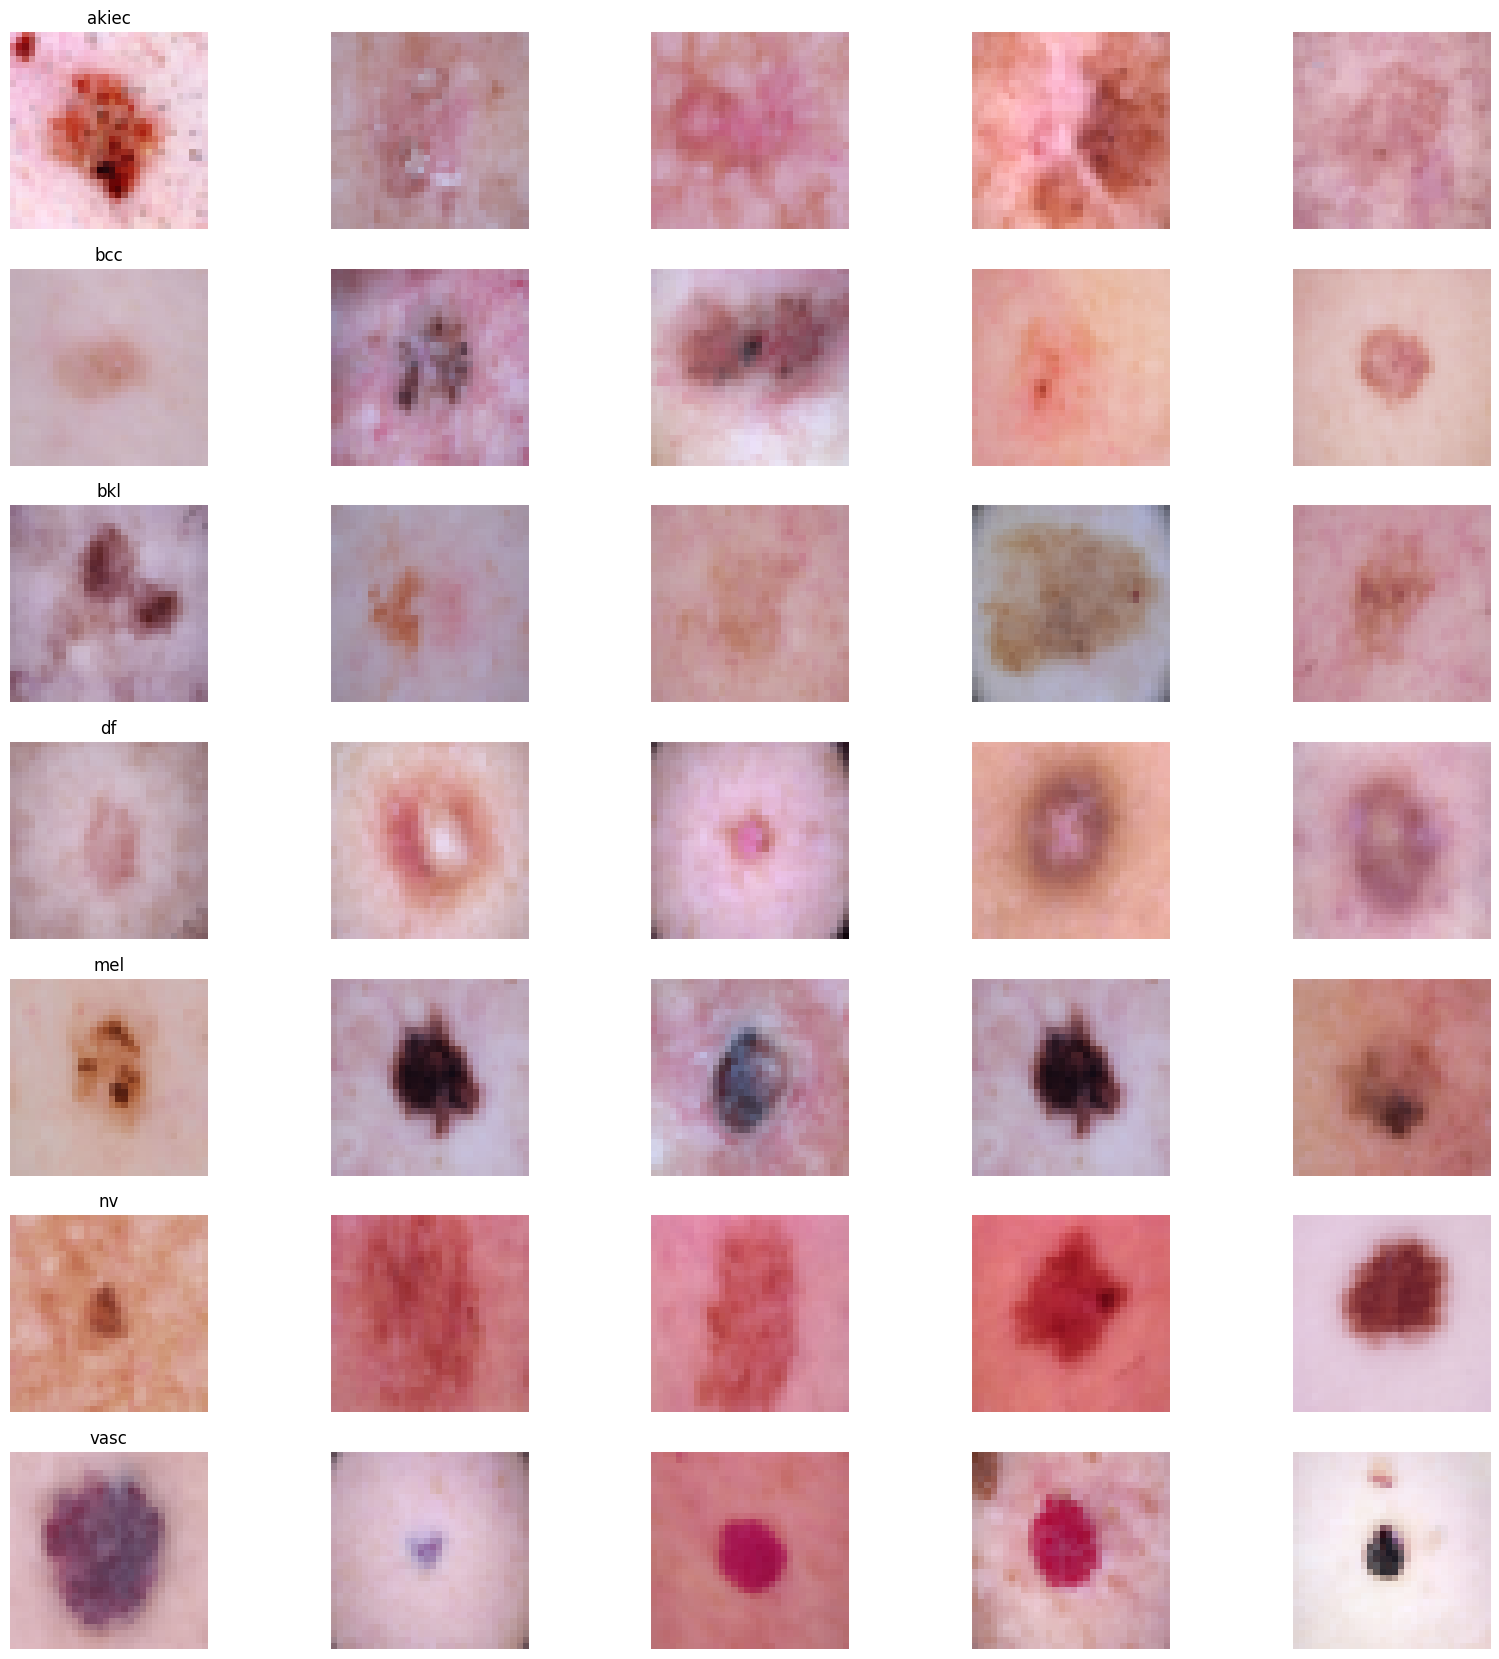

In [ ]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

# Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)


In [ ]:
# Define the model.


num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

Epoch 1/50
165/165 - 14s - loss: 1.8585 - acc: 0.2156 - val_loss: 1.7802 - val_acc: 0.2526 - 14s/epoch - 84ms/step
Epoch 2/50
165/165 - 1s - loss: 1.6149 - acc: 0.3280 - val_loss: 1.5834 - val_acc: 0.4011 - 965ms/epoch - 6ms/step
Epoch 3/50
165/165 - 1s - loss: 1.4974 - acc: 0.3893 - val_loss: 1.4983 - val_acc: 0.3840 - 957ms/epoch - 6ms/step
Epoch 4/50
165/165 - 1s - loss: 1.4210 - acc: 0.4408 - val_loss: 1.4778 - val_acc: 0.3703 - 956ms/epoch - 6ms/step
Epoch 5/50
165/165 - 2s - loss: 1.3805 - acc: 0.4400 - val_loss: 1.8345 - val_acc: 0.2926 - 2s/epoch - 13ms/step
Epoch 6/50
165/165 - 1s - loss: 1.3847 - acc: 0.4602 - val_loss: 1.2759 - val_acc: 0.4754 - 1s/epoch - 7ms/step
Epoch 7/50
165/165 - 1s - loss: 1.2877 - acc: 0.4933 - val_loss: 1.3038 - val_acc: 0.4651 - 978ms/epoch - 6ms/step
Epoch 8/50
165/165 - 1s - loss: 1.2850 - acc: 0.4949 - val_loss: 1.3061 - val_acc: 0.4686 - 971ms/epoch - 6ms/step
Epoch 9/50
165/165 - 1s - loss: 1.2284 - acc: 0.5173 - val_loss: 1.2309 - val_acc: 0.

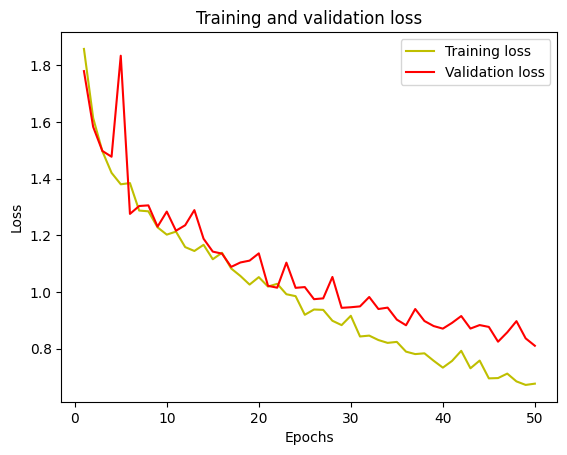

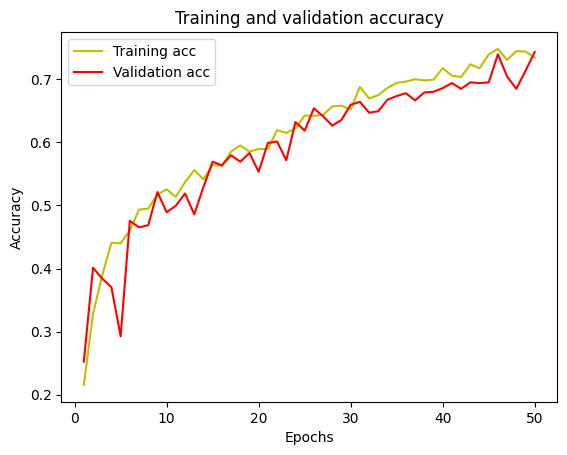

In [ ]:
# Train


batch_size = 16
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


# plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

28/28 [==============================] - 0s 2ms/step


<Axes: >

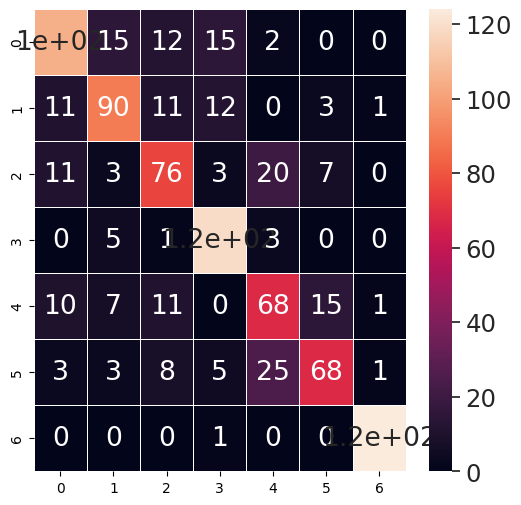

In [ ]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

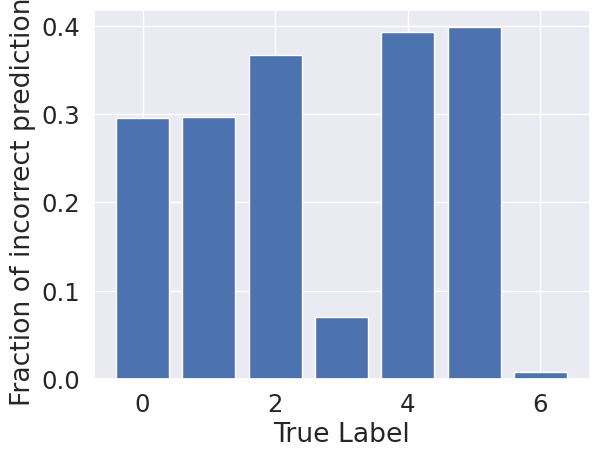

In [ ]:
# PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')